In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

# ensure project root (one level up) is on PATH
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

## Notebook variables

In [3]:
video_path = "../sample_data/08fd33_4.mp4"
output_path = "../output_videos/output_video.avi"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

## Import the model

In [4]:
from utils.import_models import ModelImporter
field_model = ModelImporter().download_field_model()

/Users/bartekbrzyski/dev/PitchAnalyzer_AI/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model downloaded to /Users/bartekbrzyski/.cache/kagglehub/models/blaku03/player-detection/pyTorch/field_recognitionv1_0/1


## Demo of the field mapper


0: 544x960 1 pitch, 1081.9ms
Speed: 8.1ms preprocess, 1081.9ms inference, 7.0ms postprocess per image at shape (1, 3, 544, 960)


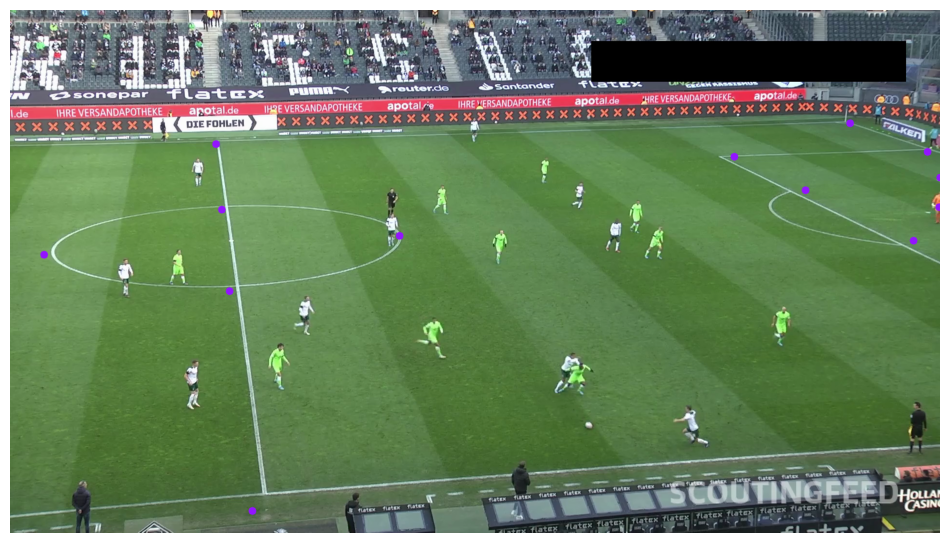

In [5]:
from utils.notebook_utils import show_image
from utils.video_utils import read_video
from trackers.field_tracker import FieldTracker
from annotators.field_annotator import FieldAnnotator

frame_generator = read_video(video_path)
first_frame = next(frame_generator)

field_tracker = FieldTracker(field_model)
first_field_track, confidence_mask = field_tracker.get_field_keypoints(first_frame)

show_image(FieldAnnotator.annotate_frame_keypoints(first_frame.copy(), first_field_track))


0: 544x960 1 pitch, 1507.3ms
Speed: 5.8ms preprocess, 1507.3ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 960)


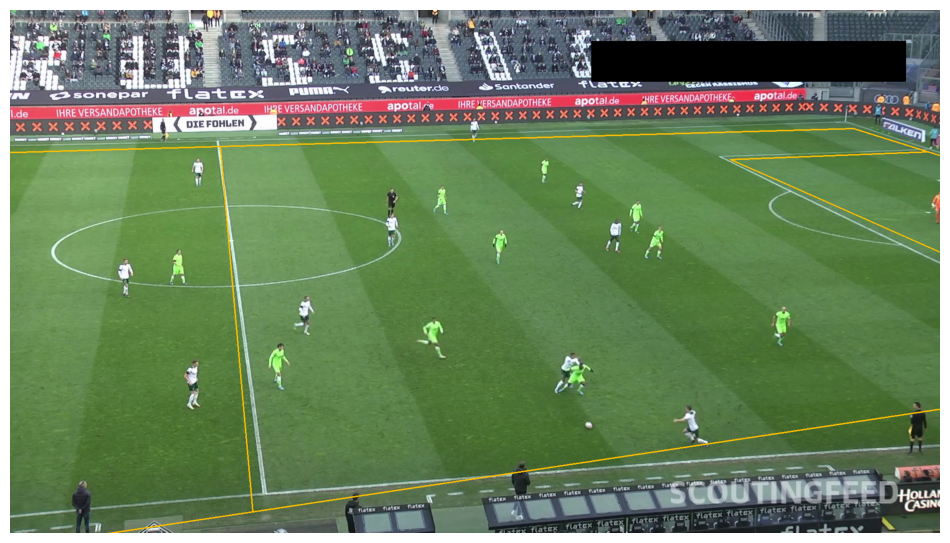

In [6]:
field_edges_keypoints = field_tracker.get_field_edges(first_frame)
show_image(FieldAnnotator.annotate_frame_edges(first_frame.copy(), field_edges_keypoints))


0: 544x960 1 pitch, 1759.9ms
Speed: 4.6ms preprocess, 1759.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 960)


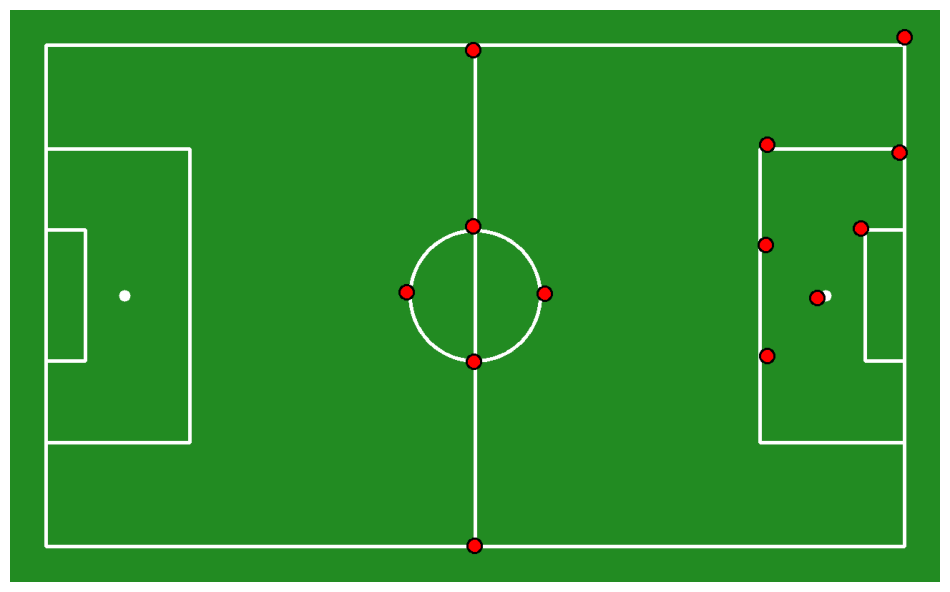

In [7]:
from utils.pitch_utils import draw_pitch, draw_points_on_pitch
from mapping_2d.soccer_field import SoccerPitchConfiguration
import supervision as sv

mapped_vert = field_tracker.map_points_2d(first_frame, first_field_track.xy[0])

pitch_img = draw_pitch(SoccerPitchConfiguration())
pitch_img = draw_points_on_pitch(
    config=SoccerPitchConfiguration(),
    xy=mapped_vert.xy[0],
    face_color=sv.Color.BLUE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=pitch_img)

show_image(pitch_img)

## Draw detected players on the 2d plane

In [8]:
from trackers.player_detector import PlayerDetector
players_model = ModelImporter().download_player_model()
frame_generator = read_video(video_path)
tracks_generator =  PlayerDetector(players_model).get_detections_from_frames(frame_generator)

Model downloaded to /Users/bartekbrzyski/.cache/kagglehub/models/blaku03/player-detection/pyTorch/player_detectionv1_1/1



0: 544x960 1 ball, 22 players, 1 referee, 841.5ms
1: 544x960 1 ball, 20 players, 3 referees, 841.5ms
2: 544x960 1 ball, 1 goalkeeper, 22 players, 1 referee, 841.5ms
3: 544x960 1 ball, 1 goalkeeper, 21 players, 2 referees, 841.5ms
4: 544x960 1 ball, 21 players, 3 referees, 841.5ms
5: 544x960 1 goalkeeper, 20 players, 3 referees, 841.5ms
6: 544x960 1 ball, 23 players, 1 referee, 841.5ms
7: 544x960 1 ball, 21 players, 1 referee, 841.5ms
8: 544x960 20 players, 4 referees, 841.5ms
9: 544x960 1 ball, 20 players, 4 referees, 841.5ms

0: 544x960 1 ball, 1 goalkeeper, 20 players, 3 referees, 2638.4ms
1: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 2638.4ms
2: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 2638.4ms
3: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 2638.4ms
4: 544x960 1 ball, 1 goalkeeper, 20 players, 3 referees, 2638.4ms
5: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 2638.4ms
6: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 2638.4ms
7: 5

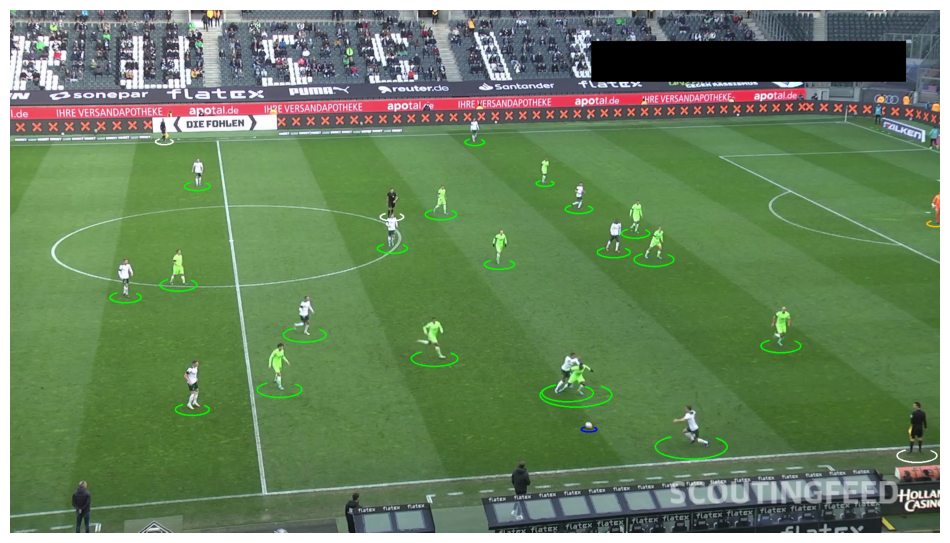

In [9]:
from annotators.player_annotator import PlayersAnnotator
from utils.notebook_utils import show_image
import itertools

frame_generator = read_video(video_path)
first_frame = next(frame_generator)

tracks_gen1, tracks_gen2 = itertools.tee(tracks_generator)
first_players_tracks = next(tracks_gen1)

tracks_generator = tracks_gen2

annotated_sample_image = PlayersAnnotator.annotate_frame(first_frame.copy(), first_players_tracks)
show_image(annotated_sample_image)


0: 544x960 1 pitch, 2739.9ms
Speed: 8.2ms preprocess, 2739.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 960)


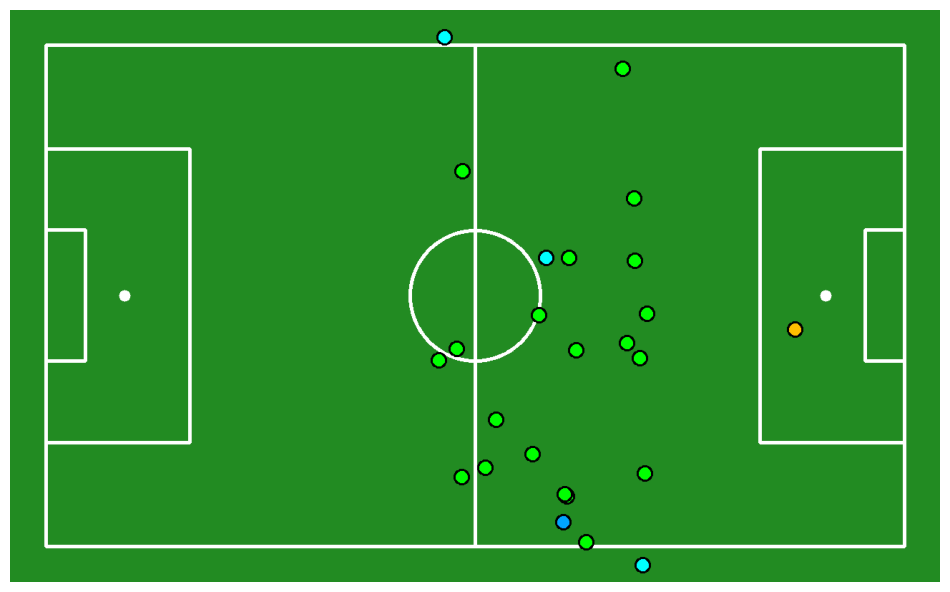

In [10]:
from annotators.pitch_2d_annotator import Pitch2DAnnotator

bottom_boxes = first_players_tracks.detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
mapped_2d_points = field_tracker.map_points_2d(first_frame, bottom_boxes)

show_image(Pitch2DAnnotator().annotate_frame(mapped_2d_points.xy[0], first_players_tracks))

In [13]:
# Annotate the full video
from utils.video_utils import save_video
import itertools

frame_generator = read_video(video_path)

frame_gen1, frame_gen2 = itertools.tee(frame_generator)

tracks_generator =  PlayerDetector(players_model).get_detections_from_frames(frame_gen1)
tracks_gen1, tracks_gen2 = itertools.tee(tracks_generator)

mapped_2d_points_generator = field_tracker.map_players_tracks_2d_generator(frame_gen2, tracks_gen1)
annotated_2d_field_generator = Pitch2DAnnotator().annotate_video(mapped_2d_points_generator, tracks_gen2)
save_video(annotated_2d_field_generator, output_path)


0: 544x960 1 ball, 21 players, 4 referees, 674.8ms
1: 544x960 1 ball, 21 players, 2 referees, 674.8ms
2: 544x960 1 ball, 21 players, 4 referees, 674.8ms
3: 544x960 1 ball, 20 players, 3 referees, 674.8ms
4: 544x960 1 ball, 21 players, 3 referees, 674.8ms
5: 544x960 1 ball, 20 players, 2 referees, 674.8ms
6: 544x960 19 players, 3 referees, 674.8ms
7: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 674.8ms
8: 544x960 1 ball, 21 players, 3 referees, 674.8ms
9: 544x960 22 players, 4 referees, 674.8ms

0: 544x960 1 ball, 1 goalkeeper, 20 players, 3 referees, 2882.1ms
1: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 2882.1ms
2: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 2882.1ms
3: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 2882.1ms
4: 544x960 1 ball, 1 goalkeeper, 20 players, 3 referees, 2882.1ms
5: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 2882.1ms
6: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 2882.1ms
7: 544x960 1 goalkeeper, 22 

5